In [8]:
import torch
import torchvision
from torchvision import transforms
from skimage import io, transform
from torch import nn

import json

import numpy as np

from training.losses import *
from training.train import *
from training.plots import *
from models.gan import *
from models.classifier import *

import matplotlib.pyplot as plt
from PIL import Image

In [9]:
BATCH_SIZE = 128
LR = 3e-4
BETAS = 0.9, 0.999

In [10]:
data = torchvision.datasets.MNIST("./../data/mnist", download=True, train=True, transform=lambda x: torch.tensor(transform.resize(np.array(x), (10, 10))).unsqueeze(0))
train_data = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)

In [11]:
base_classifier = SimpleClassifier()

In [12]:
optimizer = torch.optim.Adam(base_classifier.parameters(), lr=LR, betas=BETAS)
criterion = nn.CrossEntropyLoss()

In [13]:
base_classifier_trainer = BaseClassifierTrainer(base_classifier, criterion, optimizer, 'cpu')

In [14]:
base_res = base_classifier_trainer.train(train_data, 10)

Epoch: 0, Loss: 0.5637274754002818
Epoch: 1, Loss: 0.15635639173973703
Epoch: 2, Loss: 0.10407656707808885
Epoch: 3, Loss: 0.08150055658064273
Epoch: 4, Loss: 0.06885788896475306
Epoch: 5, Loss: 0.059589179508829825
Epoch: 6, Loss: 0.05259103921508719
Epoch: 7, Loss: 0.04770203770892535
Epoch: 8, Loss: 0.043947379370458804
Epoch: 9, Loss: 0.04150459133352265


In [15]:
data = torchvision.datasets.MNIST("./../data/mnist", download=True, train=False, transform=lambda x: torch.tensor(transform.resize(np.array(x), (10, 10))).unsqueeze(0))
train_data = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)

In [17]:
generator_model = Generator()
discriminator_model = Discriminator()
attacked_model = base_classifier.eval()

In [18]:
generator_optimizer = torch.optim.Adam(generator_model.parameters(), lr=LR, betas=BETAS)
discriminator_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=LR, betas=BETAS)

In [19]:
trainer = Trainer(generator_model, discriminator_model, attacked_model,
                  GANLoss(BATCH_SIZE, 'cpu'),
                  AttackLoss(attacked_model, BATCH_SIZE, 'cpu'),
                  discriminator_optimizer, generator_optimizer, 'cpu')

In [83]:
res = trainer.train(train_data, 10)

Epoch: 0, Generator loss: 0.6315462321807177, Discriminator loss: 1.211809638219002, ResNet loss: 1.0954145238949702,
Epoch: 1, Generator loss: 0.630618922985517, Discriminator loss: 1.2085240422151027, ResNet loss: 1.082726354782398,
Epoch: 2, Generator loss: 0.6294156962480301, Discriminator loss: 1.2056674300095973, ResNet loss: 1.071893877707995,
Epoch: 3, Generator loss: 0.6284721761177747, Discriminator loss: 1.2028635006684523, ResNet loss: 1.0617813834777245,
Epoch: 4, Generator loss: 0.6274051398803027, Discriminator loss: 1.2001395286657872, ResNet loss: 1.0541420433765802,
Epoch: 5, Generator loss: 0.6263297230769427, Discriminator loss: 1.1975054450524159, ResNet loss: 1.0477661765538728,
Epoch: 6, Generator loss: 0.6253560261848645, Discriminator loss: 1.1948851591501481, ResNet loss: 1.0408145647782545,
Epoch: 7, Generator loss: 0.6242429912090302, Discriminator loss: 1.1924363512259264, ResNet loss: 1.0337447241330757,
Epoch: 8, Generator loss: 0.6233306511854514, Discri

In [91]:
val_batch = iter(train_data).next()[0].float()
for i in range(16):
    print(F.softmax(attacked_model(val_batch), -1).cpu().detach().numpy()[i, 1], F.softmax(attacked_model(val_batch + generator_model(val_batch)), -1).cpu().detach().numpy()[i, 1])

4.2946308e-08 0.001294782
0.01491686 0.0012545917
0.9992943 0.0011356774
7.036229e-06 0.00021950477
0.00045146968 0.00061024865
0.9994929 0.0023304906
0.0009825396 0.014770121
0.00038477333 0.0025704606
7.5375337e-06 0.00039584827
4.3166224e-07 0.003731797
3.7653163e-07 8.698533e-05
1.4306884e-05 0.0049257167
4.3896403e-06 0.0007064776
3.9927832e-07 7.663164e-06
0.99993837 0.0072898166
2.9992525e-05 0.005645944


Text(0.5, 1.0, 'Fake: Prediction: 1, confidence: 0.2766471207141876')

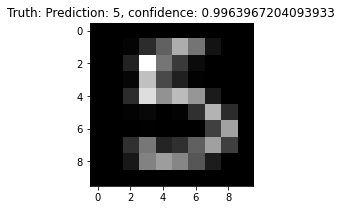

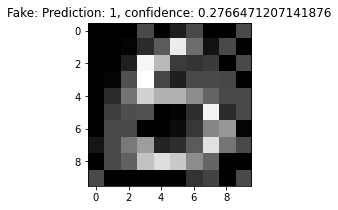

In [107]:
test_img = val_batch[15:16]
true_confs = F.softmax(attacked_model(test_img), -1).cpu().detach().numpy()[0]
fake_confs = F.softmax(attacked_model(test_img + generator_model(test_img)), -1).cpu().detach().numpy()[0]

plt.figure(figsize=(3,3))
plt.imshow(test_img[0, 0] * 127.5 + 127.5, cmap='gray')
plt.title("Truth: Prediction: {}, confidence: {}".format(np.argmax(true_confs), true_confs.max()))

plt.figure(figsize=(3,3))
plt.imshow((test_img + generator_model(test_img).cpu().detach().numpy())[0,  0] * 127.5 + 127.5, cmap='gray')
plt.title("Fake: Prediction: {}, confidence: {}".format(np.argmax(fake_confs), fake_confs.max()))

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(res[0],label="Generator loss")
plt.plot(res[1],label="Discriminator loss")
plt.plot(res[2],label="Attack loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()